# Simulating data from the Ricker Model

We have a process model with complicated behaviour that we extended to versions from which simulate any kind of data:
- Chaotic or non-chaotic
- single-species or multi-species
- dependent on exogeneous factors (Temperature only) or not
- deterministic or stochastic (that refers to fully observable or with observation error, currently)

We now want a simulator object, that let's us make choices on the model and then on the way of simulation.

In [85]:
import simulations
import matplotlib.pyplot as plt
import numpy as np

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20


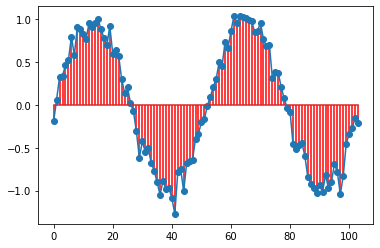

In [86]:
# create simulator object
sims = simulations.Simulator()
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=20)
sims.simulation_parameters(regime="non-chaotic", behaviour="stochastic")
sims.choose_model("single-species", "exogeneous")
x = sims.simulate()

Let's check the data we visualized quantitatively and visually.



(30, 104)


/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_38094/320075238.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


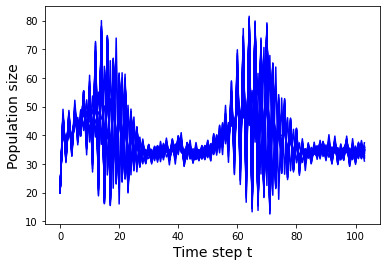

In [87]:
print(x.shape)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(np.transpose(x), color="blue")
ax.set_xlabel('Time step t', size=14)
ax.set_ylabel('Population size', size=14)
fig.show()

# Detecting chaotic behaviour

The Lyapunov exponent is a property of a function that gives information on the function regime, if it is chaotic or non-chaotic. We can compute it from the first derivative of the model.
For the Single-Species Ricker without temperature dependence, our knowledge of high-school calculus might be sufficient to find the derivative in closed form. However, if we pick one of the more complex models, we will get to our precision limits. So let's use the torch.autograd package to find the numerical derivative (based on: autograd_grad_griesler.jpynb).

In [88]:
import torch
from torch.autograd import grad

At the example of the Single-species model we just specified, let's the define the function we want to derive.
$N_{t+1} = \lambda * N * e^{-\alpha N}$. From theory we know that the regime depends on the parameter $\lambda$ that represents the exponential of the growth rate and that is defined as $\lambda = e^{r}$. $\alpha$ is the inverse of the carrying capacity, as such $\alpha = 1/k$.
First, the model parameters that were used for the above simulation we choose manually. Those are:
$r = 1.9$
$k = 20$


In [92]:
def f(N, r= 1.9, k=20):
    return torch.exp(torch.tensor(r)) * N * torch.exp(- 1/k * N)

The points that we want to take the derivative at, we just simulated. Let's use only one ensemble member for now.
Two things are here to note: We can use grad only to if $f(N)$ returns a scalar (in form of a tensor), and if every variable is contained in the graph. That means, we have to calculate the derivative of the vector stepwise for every element.



In [93]:
def lyapunov(x):
    '''
    Calculate the Lyapunov exponent of the function f(N) that has been evolved for a known N_start.
    '''
    df_dN = []
    for i in range(x.shape[1]): # stepwise derivative
        N = x[:, i]
        N = torch.tensor(N, requires_grad=True) # set requires_grad = True for computing the gradient
        dN = grad(f(N), N)
        df_dN.append(torch.tensor(dN)) # turn tuple into tensor
    df_dN = torch.cat(df_dN).detach().numpy()

    return np.mean(np.log(abs(df_dN)))

xs = x[np.random.choice(np.arange(x.shape[0]), 1), :] # pick a random ensemble member
print(lyapunov(xs))

-0.33983580686783854
